# Activation maximization

This notebook will guide you through the use of a widely used technique for studying the behaviour of convolutional neural networks. You will use a python package called `keras-vis` to apply a technique called `activation maximization`:

The idea behind activation maximization is simple: generate an input image that maximizes the output activations of a given unit (filter) in the network.

The `keras-vis` package computes the derivative of the ActivationMaximization loss with respect to the input, and uses this gradient to update the input image. ActivationMaximization loss simply outputs small values for large filter activations (the package minimizes losses during gradient descent iterations). This allows us to understand what sort of input patterns activate a particular filter. For example, for detecting the digit one (1) there could be a filter that activates for the presence of vertical lines within the input image.

For the experiments, you are going to use the `mnist` dataset from LeCun et al. 1998.

------------------------------------------------
# First part: Creating a model

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as pl

from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

Using TensorFlow backend.


## Loading the data

Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print n_train, 'train samples'
print n_test, 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


## Creating the network

Create the CNN and show its architecture

In [27]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Convolution2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Convolution2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Convolution2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(25, activation='relu', name='l4')(flat)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l0 (InputLayer)              (None, 28, 28, 1)         0         
_________________________________________________________________
l1 (Conv2D)                  (None, 28, 28, 9)         234       
_________________________________________________________________
l1_mp (MaxPooling2D)         (None, 14, 14, 9)         0         
_________________________________________________________________
l2 (Conv2D)                  (None, 14, 14, 9)         2034      
_________________________________________________________________
l2_mp (MaxPooling2D)         (None, 7, 7, 9)           0         
_________________________________________________________________
l3 (Conv2D)                  (None, 7, 7, 16)          1312      
_________________________________________________________________
l3_mp (MaxPooling2D)         (None, 3, 3, 16)          0         
__________

## Training the network

Define some constants and train de CNN

In [28]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 356us/step - loss: 0.5544 - acc: 0.8257 - val_loss: 0.2516 - val_acc: 0.9220
Epoch 2/10
60000/60000 [==============================] - 19s 308us/step - loss: 0.1620 - acc: 0.9513 - val_loss: 0.1309 - val_acc: 0.9597
Epoch 3/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.1083 - acc: 0.9665 - val_loss: 0.0861 - val_acc: 0.9722
Epoch 4/10
60000/60000 [==============================] - 19s 313us/step - loss: 0.0852 - acc: 0.9741 - val_loss: 0.0942 - val_acc: 0.9713
Epoch 5/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.0708 - acc: 0.9777 - val_loss: 0.0573 - val_acc: 0.9802
Epoch 6/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.0605 - acc: 0.9812 - val_loss: 0.0569 - val_acc: 0.9820
Epoch 7/10
60000/60000 [==============================] - 19s 310us/step - loss: 0.0521 - acc: 0.9841 - val_loss: 0.

Show the performance of the model

Test score: 0.0446246750531
Test accuracy: 0.9861


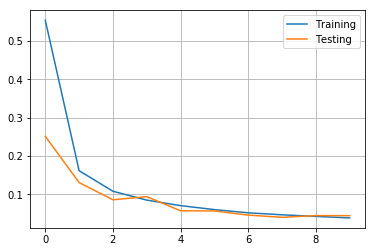

In [29]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [30]:
pred = model.predict_on_batch(X_test)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

array([[ 968,    0,    3,    0,    0,    1,    2,    1,    2,    3],
       [   0, 1128,    1,    1,    1,    1,    1,    1,    0,    1],
       [   2,    0, 1017,    6,    0,    0,    0,    6,    1,    0],
       [   0,    0,    1, 1003,    0,    3,    0,    2,    0,    1],
       [   0,    0,    2,    0,  964,    0,    2,    4,    1,    9],
       [   1,    0,    0,    5,    0,  883,    1,    2,    0,    0],
       [   4,    2,    3,    1,    3,   10,  933,    0,    2,    0],
       [   0,    2,    2,    1,    0,    0,    0, 1021,    0,    2],
       [   0,    0,    2,    6,    0,    3,    0,    4,  951,    8],
       [   0,    0,    0,    3,    2,    4,    0,    7,    0,  993]])

-------------------------
# Second part: maximizing activations

## Loading the packages

In [7]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from __future__ import print_function

## Activation maximization keeping the softmax activation at the output
Activation maximization does not work if the activation function is a Softmax. Let us see this behaviour

In [31]:
# select the last layer
layer_idx = utils.find_layer_idx(model, 'l5')

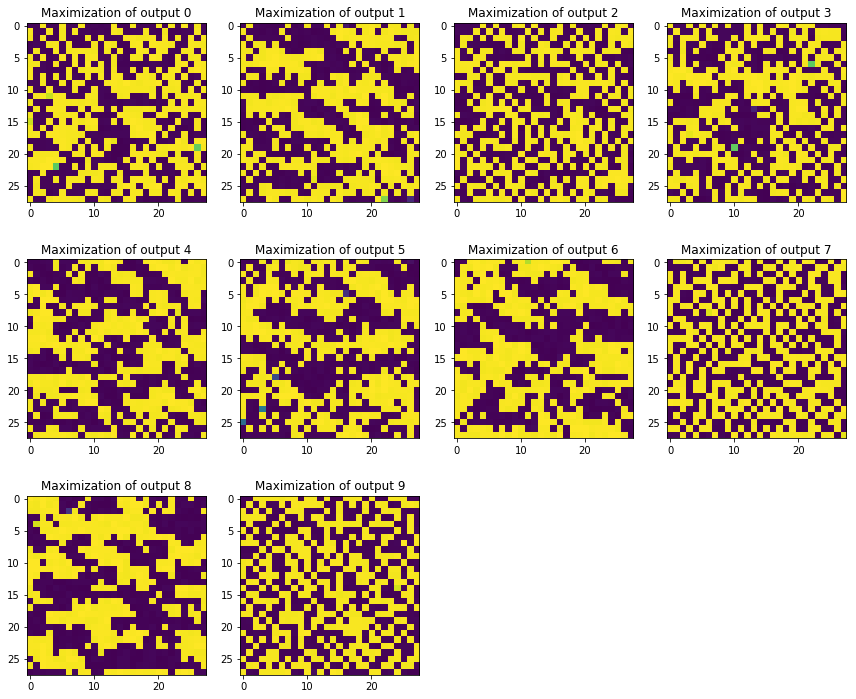

In [9]:
pl.figure(figsize=(12,10))
for output_idx in np.arange(10):
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0.0, 1.0))
    pl.subplot(3, 4, output_idx+1)
    pl.title('Maximization of output {}'.format(output_idx))
    pl.imshow(img[..., 0])
pl.tight_layout()

It does not work! The reason is that when using Softmax as activation function, maximizing an output node can be done by minimizing other outputs. It is the only activation that depends on other node output(s) in the layer.

## Activation maximization without the softmax activation at the output

The following cell replaces the Softmax activation function by a Linear activation function

In [41]:
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Visualize the image that maximizes the first output (0) of the network

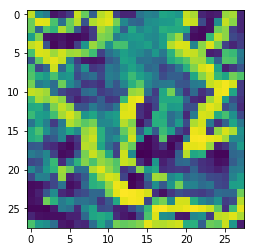

In [48]:
img = visualize_activation(model, layer_idx, filter_indices=0, input_range=(0.0, 1.0), tv_weight=0.0)
pl.imshow(img[..., 0])

The last result was found without using the `tv_weight` regularizer (tv_weight=0.0). However, we know that using the parameter tv_weight makes the generated image more realistic.

## Questions

<div class="alert alert-block alert-info">
<ul>
    <li>Test different values of `tv_weight`</li>
    <ul>
        <li>Try values between 0.1 and 20 (for example: [0.125, 0.25, 0.5, 1, 2, 4, 8, 16])</li>
        <li>Select the regularization parameter that gives the best images (more realistic)</li>
        <li>Show the images that maximize each one of the outputs of the network</li>
    </ul>
    <li>Maximize two outputs at the same time (filter_indices=[f1, f2])</li>
    <ul>
        <li>Try two classes with similar shape like 1 and 7 or 4 and 9</li>
        <li>Try two classes with very different shapes like 0 and 1 or 7 and 8</li>
        <li>How activation maximization can be useful for understanding a deep neural network? Explain</li>
    </ul>
</ul>
</div>